# Exploring the Sonic Landscape of Spotify


If you're like me, you love music. I love music and I love to find new music. If you don't already know - which if you're reading this you probably do - Spotify is one of the top streaming services for music on the internet, and it includes amazing tools that help you to discover new music based on what you listen to. It does this through a combination of different algortihms, including collaboritive filtering where similar usage between users is tracked and used to generate recommendations, or content based recommendations which recommend new songs based on similar information between the information linked to a song. Like a song? On Spotify, you can listen to that songs 'radio', which will collect a group of songs similar to that song in some way or a combination of ways. What if you like a song, but don't care about any information other than just the sound in it? Sometimes, that is all I want to hear.

This project attempts to create a music recomendation system based the information in the sound of the music alone. It will help a user to find new music through similar sounding songs. To do that, it will also explore the similarities between all music, and attempt to capture the timbre, rhythm, and style of a song mathematically.

### What is sound?

Sound is always around us. Throughout our lives, we grow to discern different sounds from others. Music is no different - there are many types of music and music is often a combination of many different kinds of sounds and rhythms that we can also discern apart some kinds from others. But can we quantify that information for ourselves? Sometimes, music is categorized into genres, meaning that a genre is a group of music with similar qualities of style, form, rhythm, timbre, instruments, or culture. But not every musical artist creates in the same genre, or not every genre contains the same kind of music. So what is sound and how to do we judge ...

1. What is sound
2. What is a signal, frequency
3. What does a waveform look like
4. What does music look like
5. Why not just use the signal
6. What is Fourier transform
7. What is a Mel spectogram
8. What is timbre







# Outline of the Project

Steps of the project:

- Scrape tracks from Spotify's API
- Convert Waveforms to Mel Spectograms
- Train an autoencoder network to extract latent features from the audio information
- Use UMAP for dimensionality reduction to view the latent space, EDA, and make recommendations
- Results and conclusions

# Model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization, Conv1D, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from src.DataGenerator import AudioDataGenerator
from src.LatentSpace import LatentSpace
from src.helper_functions import plot_reconstruction

In [2]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=128000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128))


Found 125440 files for Training set
Found 2560 files for Test set


In [3]:
img_width = 128
img_height = 128
num_channels=1
kernel_size = 5
strides = 2

In [21]:
class Time_Freq_Autoencoder_Builder:
    
    def build(width, height, depth, filters=(32,64,128,256), latent_dim=256, kernel_size=5):
        
        strides = 2
        
        input_shape = (height, width, depth)
        inputs = Input(shape = input_shape)
        
        chan_dim = -1
        
        x_time = Reshape(target_shape=(height,width))(inputs)
        x_freq = Reshape(target_shape=(height,width))(tf.transpose(inputs, perm=[0,2,1,3]))
        
        for f in filters:
            
            x_time = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_time)
            x_time = BatchNormalization(axis=chan_dim)(x_time)
            
        x_time = Flatten()(x_time)
        latent_time = Dense(latent_dim//2)(x_time)
        
        for f in filters:
            
            x_freq = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_freq)
            x_freq = BatchNormalization(axis=chan_dim)(x_freq)
            
        x_freq = Flatten()(x_freq)
        latent_freq = Dense(latent_dim//2)(x_freq)
        
        
        latent_concat = tf.keras.layers.Concatenate(axis=1)([latent_time, latent_freq])
        
        encoder = Model(inputs, latent_concat, name='encoder')
        
        latent_inputs = Input(shape=((latent_dim//2)*2))
        
        x = Dense(16384, activation='relu')(latent_inputs)
        x = Reshape(target_shape=(8,8,256))(x)
        
        for f in filters[::-1]:
            
            x = Conv2DTranspose(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
            x = BatchNormalization(axis=chan_dim)(x)
            
        x = Conv2DTranspose(depth, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
        
        outputs = x
        
        decoder = Model(latent_inputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        return (encoder, decoder, autoencoder)
    

class Time_Freq_Autoencoder(tf.keras.Model):
    
    def __init__(self, image_width, image_height, image_depth=1, latent_dim=256, kernel_size=5):
        super().__init__()
        
        self.encoder, self.decoder, self.autoencoder = Time_Freq_Autoencoder_Builder.build(width=image_width, height=image_height, depth=image_depth, latent_dim=256, kernel_size=kernel_size)
        
    def call(self, x):
        autoencoded = self.autoencoder(x)
        return autoencoded
    
autoencoder = Time_Freq_Autoencoder(image_width=img_width, image_height=img_height, latent_dim=256, kernel_size=5)

In [22]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [23]:
autoencoder.build(input_shape=(None,img_height,img_width,num_channels))

In [24]:
autoencoder.summary()

Model: "time__freq__autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 256)               1000384   
                                                                 
 decoder (Functional)        (None, 128, 128, 1)       6927489   
                                                                 
 autoencoder (Functional)    (None, 128, 128, 1)       7927873   
                                                                 
Total params: 7,927,873
Trainable params: 7,924,993
Non-trainable params: 2,880
_________________________________________________________________


In [25]:
autoencoder.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose_1 (TFOp  (None, 128, 128, 1)  0          ['input_3[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 reshape_3 (Reshape)            (None, 128, 128)     0           ['input_3[0][0]']                
                                                                                            

In [26]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_5 (Dense)             (None, 16384)             4210688   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 256)      1638656   
 ranspose)                                                       
                                                                 
 batch_normalization_20 (Bat  (None, 16, 16, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 128)      8193

In [27]:
# hist = autoencoder.fit(data_gen.train,
#                        batch_size=data_gen.batch_size,
#                        epochs=20,
#                        validation_data=data_gen.test)

In [5]:
autoencoder_path = 'data/autoencoder_256dim_time_freq_128k_20epochs'
#autoencoder.save(autoencoder_path)
autoencoder = tf.keras.models.load_model(autoencoder_path)

2022-08-22 18:02:02.275405: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


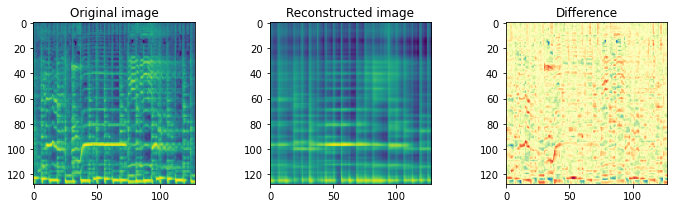

In [6]:
test_img = data_gen.take(1)[0]
prediction = autoencoder(test_img)

plot_reconstruction(test_img, prediction, 1)

# Build Latent Space from Encoder

In [7]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather',
                        latent_dims=256,
                        output_size=(128, 128),
                        num_tiles=64)

Found 278581 files for Generator set


In [8]:
# latent_space.build()
# latent_space.save(autoencoder_path)

In [9]:
latent_space.load(autoencoder_path)

Loaded tracks.
Loaded artists.
Loaded genres.
loaded scaler


# EDA

In [10]:
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
import umap.plot
from sklearn.cluster import MiniBatchKMeans
from pyarrow import feather
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data = latent_space.tracks[latent_space.latent_cols]

In [12]:
data

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,...,latent_246,latent_247,latent_248,latent_249,latent_250,latent_251,latent_252,latent_253,latent_254,latent_255
0,-0.931030,-0.627242,0.101877,-0.478947,-0.251039,0.625820,0.492011,0.245462,1.223624,1.266876,...,0.485883,-0.092142,0.650495,-0.227040,0.535643,1.033859,-1.614182,1.753295,0.605785,-0.187070
1,1.206389,1.273550,0.557408,0.325929,-0.081681,0.516642,0.388528,-0.636514,-1.006628,0.178256,...,0.914649,-1.042892,-1.139270,1.009379,1.087832,-0.930393,-0.923536,0.469667,0.460890,-0.881931
2,0.453407,0.416593,1.587540,2.043391,0.452955,-0.940199,1.172614,1.251194,-0.405293,-0.797569,...,0.239428,-0.673582,-0.153477,0.071661,1.029765,-0.788574,0.129701,0.479035,1.027465,-0.545689
3,1.088135,1.588436,0.318530,-0.424181,-0.586271,-0.366699,0.590407,-1.637880,-1.415497,0.426565,...,0.545312,-0.824384,-1.029909,-0.059706,0.542504,-0.812980,0.716340,-0.678522,-0.678320,-1.346973
4,0.599516,0.680319,0.226810,-0.012162,-1.036578,-0.090334,-0.514148,-0.163585,-0.444001,0.675905,...,0.983848,-0.790166,-0.988888,0.062000,0.607584,-0.214391,-0.704413,0.701064,0.099844,-0.888792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278576,-0.141969,-0.228623,-0.765526,0.119331,-0.532499,0.538567,-0.038078,-0.131387,0.338143,0.779431,...,0.164500,-0.306768,0.007112,-0.020533,0.786471,-0.473560,-1.083223,0.942838,1.161088,-0.133268
278577,1.333951,0.999337,1.281820,0.438317,1.391258,-0.022001,0.716352,1.791649,-1.956721,-1.713659,...,0.664482,-0.844193,-0.803701,0.959144,0.627290,-1.160024,-0.076161,-0.148335,0.377666,-1.020388
278578,-0.593010,-0.709486,0.669053,-1.109215,0.065182,1.865841,-0.141215,0.290322,1.511206,0.327515,...,-0.150501,0.634205,-0.319659,-1.520174,-1.262274,1.590920,-0.515604,-0.776541,-1.779178,0.597594
278579,0.191761,-0.075300,0.949650,0.327106,0.304808,-0.639967,-0.004349,0.091453,-0.074483,0.988164,...,-0.254475,-0.003452,0.249319,-0.503139,-0.402495,-0.834654,-0.083222,-0.214365,0.070678,0.366572


In [36]:
embedding = umap.UMAP(n_neighbors=500, min_dist=.5).fit_transform(data)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


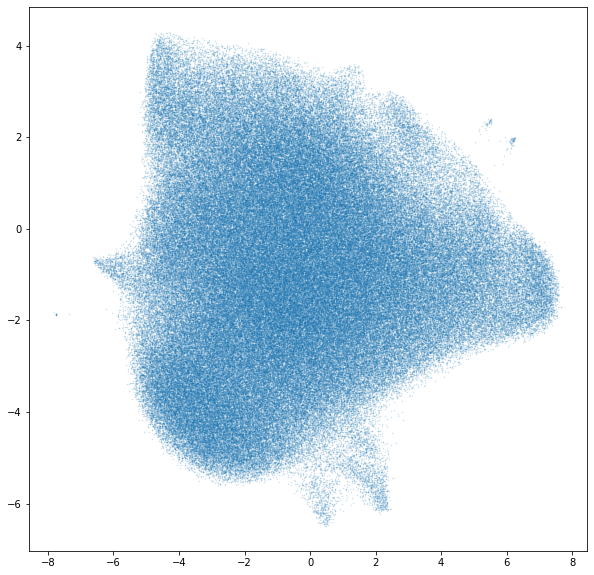

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.scatter(*embedding.T, s=0.3, alpha=.2)

/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


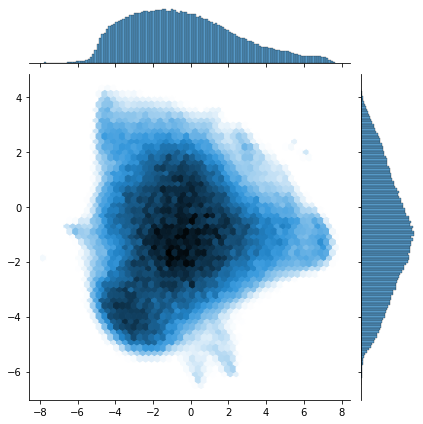

In [38]:
sns.jointplot(*embedding.T, kind='hex')

In [40]:
latent_space.genres.index

RangeIndex(start=0, stop=3799, step=1)

In [41]:
genre_map = umap.UMAP(n_neighbors=100, min_dist=.1).fit(latent_space.genres[latent_space.latent_cols])
genre_hover_data = pd.DataFrame(latent_space.genres.genre)
umap.plot.output_notebook()
p = umap.plot.interactive(genre_map, point_size=10, hover_data=genre_hover_data)
umap.plot.show(p)

Loading BokehJS ...

In [42]:

data_sample = latent_space.genres[latent_space.latent_cols]
results=[]
kmeans_predictions = []
gmm_predictions = []
for k in range(2,127):
    kmeans = MiniBatchKMeans(n_clusters=k).fit(data_sample)
    predict = kmeans.predict(data_sample)
    result = {
        'k':k,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette_score(data_sample, predict),
    }
    results.append(result)
    kmeans_predictions.append(predict)
    print(result, end='\r')
cluster_results = pd.DataFrame(results)

In [43]:
clusters = 10

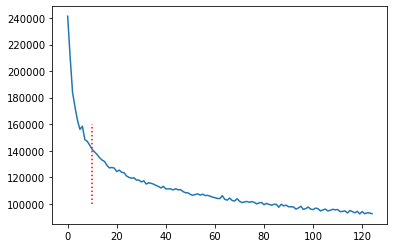

In [44]:
fig, ax = plt.subplots()
cluster_results.inertia.plot(ax=ax)
ax.vlines(x=clusters, ymin=100000, ymax=160000, colors='red', linestyles='dotted')

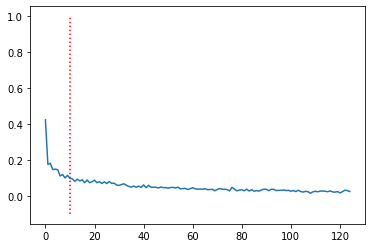

In [45]:
fig, ax = plt.subplots()

cluster_results.silhouette.plot()
ax.vlines(x=clusters, ymin=-.1, ymax=1, colors='red', linestyles='dotted')

In [46]:
genre_projected = latent_space.genres[latent_space.latent_cols].astype('float32')
kmeans_genre = MiniBatchKMeans(n_clusters=clusters).fit(genre_projected)
p = umap.plot.interactive(genre_map, labels = kmeans_genre.predict(genre_projected), point_size=10, hover_data=genre_hover_data)
umap.plot.show(p)

# Get Recommendations

In [13]:
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

f = open('data/apikeys/.apikeys.json')
apikeys = json.load(f)
SPOTIPY_CLIENT_ID = apikeys['clientId']
SPOTIPY_CLIENT_SECRET = apikeys['clientSecret']

credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)

spotify = spotipy.Spotify(client_credentials_manager=credentials_manager)

In [20]:
search = 'gary numan metal'

In [25]:
id_ = spotify.search(search, type='track')['tracks']['items'][0]['id']
link = spotify.track(id_)['preview_url']
print(spotify.track(id_)['name'])
print(spotify.track(id_)['artists'][0]['name'])
print(link)

Metal
Gary Numan
https://p.scdn.co/mp3-preview/83e35813e1da71cc5ef2b6d2e1739791667f3208?cid=5f818fbc1c374e239ee0139163734165


In [26]:
vector = latent_space.get_vector_from_preview_link(link, id_)

/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
vector = pd.DataFrame(vector, columns=latent_space.latent_cols)

In [28]:
latent_space.get_similarity(vector, latent_space.tracks, subset=latent_space.latent_cols)[['track_name','track_uri','artist_name','similarity']]

,track_name,track_uri,artist_name,similarity
0,Crawl Home,spotify:track:77Al0O42PXCiU35JZoAyhz,Desert Sessions,0.678607
1,Malaguena,spotify:track:4dnd6ArVnJnPmsXrDLM6sO,Benise,0.665396
2,Step in the Name (Radio Edit),spotify:track:3XmMK2QKPLxsbS5PuPa956,Bryan Popin,0.656353
3,無能用者,spotify:track:0VE8rBPhnuKznma1wLeibD,黃秋生,0.653503
4,Amsterdam [ABGT221] - Smith & Pledger Update,spotify:track:3b5C12I3iLyviNyAeqPVP3,Smith & Pledger,0.653391
5,Voz no Ouvido,spotify:track:2J5Pqvimy4NMgHfenEYTYI,Pedro Mariano,0.651901
6,Her kommer Julius,spotify:track:6WllUUBOmvDkQGBedw87un,Terje Formoe,0.648873
7,Praise the Lord Every Day,spotify:track:0LtfXpNnGPhoRoFndutmco,Yancy,0.643570
8,Souviens-toi,spotify:track:4QnRpJrSS1bTfBc7XUy66T,Dindo Yogo,0.641061
9,Agadoo,spotify:track:7vpWDeKqM6sVTpt2WAdpY1,Black Lace,0.638929


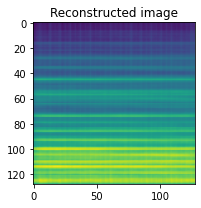

In [29]:
latent_space.plot_reconstruction_from_vector(vector)

In [31]:
latent_space.search_for_recommendations('gary numan metal', num=10)

Metal
Gary Numan
https://p.scdn.co/mp3-preview/83e35813e1da71cc5ef2b6d2e1739791667f3208?cid=5f818fbc1c374e239ee0139163734165


/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,track_name,track_uri,artist_name,similarity,track_popularity
0,Crawl Home,spotify:track:77Al0O42PXCiU35JZoAyhz,Desert Sessions,0.678607,33
1,Malaguena,spotify:track:4dnd6ArVnJnPmsXrDLM6sO,Benise,0.665396,33
2,Step in the Name (Radio Edit),spotify:track:3XmMK2QKPLxsbS5PuPa956,Bryan Popin,0.656353,23
3,Amsterdam [ABGT221] - Smith & Pledger Update,spotify:track:3b5C12I3iLyviNyAeqPVP3,Smith & Pledger,0.653391,19
4,Voz no Ouvido,spotify:track:2J5Pqvimy4NMgHfenEYTYI,Pedro Mariano,0.651901,32
5,Her kommer Julius,spotify:track:6WllUUBOmvDkQGBedw87un,Terje Formoe,0.648873,43
6,Praise the Lord Every Day,spotify:track:0LtfXpNnGPhoRoFndutmco,Yancy,0.643570,35
7,Agadoo,spotify:track:7vpWDeKqM6sVTpt2WAdpY1,Black Lace,0.638929,47
8,Woods of Mystery,spotify:track:0gJzcPxdJDa8XCFIkFzHGk,Theophany,0.638103,40
9,How It Should Be (Sha Sha),spotify:track:77h5SC6UU6kfKNSGQ9hZ4k,Ben Kweller,0.637376,31
